## 1. Import Libraries

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2.Display Settings

In [3]:
pd.set_option("display.max_column",None) #Display all the columns

In [4]:
sklearn.set_config(transform_output="pandas") # sklearn output pandas setting

In [5]:
warnings.filterwarnings("ignore")

## 3.Read the Data

In [6]:
path=r"C:\Users\yagku\Downloads\SageMaker_Flight_Prediction-master\SageMaker_Flight_Prediction-master\Dataset\train.csv"
train=pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-04-09,Banglore,Delhi,06:00:00,08:45:00,165,0.0,No Info,7229
1,Jet Airways,2019-05-18,Delhi,Cochin,13:00:00,19:00:00,360,1.0,In-flight meal not included,12373
2,Air Asia,2019-04-15,Kolkata,Banglore,07:35:00,19:25:00,710,1.0,No Info,5192
3,Jet Airways,2019-05-09,Kolkata,Banglore,14:05:00,20:45:00,400,1.0,No Info,14781
4,Jet Airways,2019-06-03,Delhi,Cochin,22:50:00,19:00:00,1210,1.0,In-flight meal not included,10262
...,...,...,...,...,...,...,...,...,...,...
6395,Spicejet,2019-04-09,Banglore,Delhi,21:10:00,00:05:00,175,0.0,No Info,3971
6396,Jet Airways,2019-06-09,Delhi,Cochin,14:00:00,12:35:00,1355,1.0,In-flight meal not included,10262
6397,Indigo,2019-05-15,Banglore,Delhi,20:00:00,22:50:00,170,0.0,No Info,4823
6398,Goair,2019-04-24,Banglore,Delhi,20:55:00,23:40:00,165,0.0,No Info,3419


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6400 non-null   object 
 1   date_of_journey  6400 non-null   object 
 2   source           6400 non-null   object 
 3   destination      6400 non-null   object 
 4   dep_time         6400 non-null   object 
 5   arrival_time     6400 non-null   object 
 6   duration         6400 non-null   int64  
 7   total_stops      6400 non-null   float64
 8   additional_info  6400 non-null   object 
 9   price            6400 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 500.1+ KB


In [8]:
x_train=train.drop(columns="price")
y_train=train.price.copy()

## 4. Tranformation Opration

### 4.1. Airline

In [10]:
x_train.airline

0       Jet Airways
1       Jet Airways
2          Air Asia
3       Jet Airways
4       Jet Airways
           ...     
6395       Spicejet
6396    Jet Airways
6397         Indigo
6398          Goair
6399         Indigo
Name: airline, Length: 6400, dtype: object

In [12]:
air_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2)),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])
air_transformer.fit_transform(x_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6395,0.0,0.0,0.0,0.0,1.0
6396,0.0,0.0,1.0,0.0,0.0
6397,0.0,1.0,0.0,0.0,0.0
6398,0.0,0.0,0.0,0.0,1.0


### 4.2. Date of Journey

In [13]:
train.date_of_journey

0       2019-04-09
1       2019-05-18
2       2019-04-15
3       2019-05-09
4       2019-06-03
           ...    
6395    2019-04-09
6396    2019-06-09
6397    2019-05-15
6398    2019-04-24
6399    2019-03-09
Name: date_of_journey, Length: 6400, dtype: object

In [14]:
feature_extract=["month", "week", "day_of_week", 'day_of_month', "day_of_year", "weekend"]
doj_transfrom= Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=feature_extract,yearfirst=True,format="mixed")),
    ("sclar",MinMaxScaler())
])
doj_transfrom.fit_transform(x_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_month,date_of_journey_day_of_year,date_of_journey_weekend
0,0.333333,0.352941,0.166667,0.307692,0.330508,0.0
1,0.666667,0.647059,0.833333,0.653846,0.661017,1.0
2,0.333333,0.411765,0.000000,0.538462,0.381356,0.0
3,0.666667,0.588235,0.500000,0.307692,0.584746,0.0
4,1.000000,0.823529,0.000000,0.076923,0.796610,0.0
...,...,...,...,...,...,...
6395,0.333333,0.352941,0.166667,0.307692,0.330508,0.0
6396,1.000000,0.823529,1.000000,0.307692,0.847458,1.0
6397,0.666667,0.647059,0.333333,0.538462,0.635593,0.0
6398,0.333333,0.470588,0.333333,0.884615,0.457627,0.0


### 4.3. Source & destination

In [15]:
train.source

0       Banglore
1          Delhi
2        Kolkata
3        Kolkata
4          Delhi
          ...   
6395    Banglore
6396       Delhi
6397    Banglore
6398    Banglore
6399       Delhi
Name: source, Length: 6400, dtype: object

In [16]:
train.destination

0          Delhi
1         Cochin
2       Banglore
3       Banglore
4         Cochin
          ...   
6395       Delhi
6396      Cochin
6397       Delhi
6398       Delhi
6399      Cochin
Name: destination, Length: 6400, dtype: object

In [17]:
location_subset=x_train.loc[:,["source","destination"]]
location_pipe=Pipeline(steps=[
    ("groper",RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2)),
    ("encoder",MeanEncoder()),
    ("sclar",PowerTransformer())
])
location_pipe.fit_transform(location_subset,y_train )

,source,destination
0,-0.891875,-1.817926
1,1.041923,1.040893
2,-0.167719,-0.166677
3,-0.167719,-0.166677
4,1.041923,1.040893
...,...,...
6395,-0.891875,-1.817926
6396,1.041923,1.040893
6397,-0.891875,-1.817926
6398,-0.891875,-1.817926


In [18]:
np.union1d(
    x_train.source.unique(),
     x_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [19]:
def is_north(X):
    column=X.columns.to_list()
    north=["Delhi","kolkata","New Delhi","Mumbai"]
    return (
        X.assign(
            **{
                f"{col}_is_north": X.loc[:,col].isin(north).astype(int)
                for col in column
            }
        )
        .drop(columns=location_subset)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)
    

,source_is_north,destination_is_north
0,0,1
1,1,0
2,0,0
3,0,0
4,1,0
...,...,...
6395,0,1
6396,1,0
6397,0,1
6398,0,1


### 4.4 dep_time & arrival_time

In [21]:
train.dep_time

0       06:00:00
1       13:00:00
2       07:35:00
3       14:05:00
4       22:50:00
          ...   
6395    21:10:00
6396    14:00:00
6397    20:00:00
6398    20:55:00
6399    02:35:00
Name: dep_time, Length: 6400, dtype: object

In [22]:
train.arrival_time

0       08:45:00
1       19:00:00
2       19:25:00
3       20:45:00
4       19:00:00
          ...   
6395    00:05:00
6396    12:35:00
6397    22:50:00
6398    23:40:00
6399    08:30:00
Name: arrival_time, Length: 6400, dtype: object

In [23]:
time_subset=x_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,06:00:00,08:45:00
1,13:00:00,19:00:00
2,07:35:00,19:25:00
3,14:05:00,20:45:00
4,22:50:00,19:00:00
...,...,...
6395,21:10:00,00:05:00
6396,14:00:00,12:35:00
6397,20:00:00,22:50:00
6398,20:55:00,23:40:00


In [24]:
time_pipe1=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("sclar",MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.260870,0.000000,0.347826,0.818182
1,0.565217,0.000000,0.826087,0.000000
2,0.304348,0.636364,0.826087,0.454545
3,0.608696,0.090909,0.869565,0.818182
4,0.956522,0.909091,0.826087,0.000000
...,...,...,...,...
6395,0.913043,0.181818,0.000000,0.090909
6396,0.608696,0.000000,0.521739,0.636364
6397,0.869565,0.000000,0.956522,0.909091
6398,0.869565,1.000000,1.000000,0.727273


In [25]:
def part_of_day(x,morning=4,noon=12,evening=16,night=20):
   columns=x.columns.to_list()
   X_temp=x.assign(**{
       col:pd.to_datetime(x.loc[:,col]).dt.hour
       for col in columns
   })
   return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, evening, inclusive="left"),
				 X_temp.loc[:, col].between(evening, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,afternoon,evening
2,morning,evening
3,afternoon,night
4,night,evening
...,...,...
6395,night,night
6396,afternoon,afternoon
6397,night,night
6398,night,night


In [26]:
time_pipe2=Pipeline(steps=[
    ("part",FunctionTransformer(func=part_of_day)),
    ("encoder",CountFrequencyEncoder()),
    ("sclar",MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.917197
1,0.000000,0.719745
2,1.000000,0.719745
3,0.000000,1.000000
4,0.156497,0.719745
...,...,...
6395,0.156497,1.000000
6396,0.000000,0.000000
6397,0.156497,1.000000
6398,0.156497,1.000000


In [27]:
time_transfrom=FeatureUnion(transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])
time_transfrom.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.260870,0.000000,0.347826,0.818182,1.000000,0.917197
1,0.565217,0.000000,0.826087,0.000000,0.000000,0.719745
2,0.304348,0.636364,0.826087,0.454545,1.000000,0.719745
3,0.608696,0.090909,0.869565,0.818182,0.000000,1.000000
4,0.956522,0.909091,0.826087,0.000000,0.156497,0.719745
...,...,...,...,...,...,...
6395,0.913043,0.181818,0.000000,0.090909,0.156497,1.000000
6396,0.608696,0.000000,0.521739,0.636364,0.000000,0.000000
6397,0.869565,0.000000,0.956522,0.909091,0.156497,1.000000
6398,0.869565,1.000000,1.000000,0.727273,0.156497,1.000000


### 4.5 Duration

In [28]:
x_train.duration

0        165
1        360
2        710
3        400
4       1210
        ... 
6395     175
6396    1355
6397     170
6398     165
6399     355
Name: duration, Length: 6400, dtype: int64

In [29]:
x_train.total_stops=x_train.total_stops.fillna(0)

In [30]:
(
    x_train.duration
    .quantile([0.25,0.50,0.75])
    .values
    .reshape(-1,1)
)

array([[170.],
       [500.],
       [910.]])

In [31]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variable=None, percentiles=[0.25, 0.50, 0.75], gamma=0.5):
        self.variable = variable
        self.percentiles = percentiles
        self.gamma = gamma
        self.reference = None
        
    def fit(self, X, y=None):
        if self.variable is None:
            self.variable = X.select_dtypes(include="number").columns.tolist()
        
        self.reference = {
            col: X.loc[:, col].quantile(self.percentiles).values.reshape(-1, 1)
            for col in self.variable
        }
        return self
    
    def transform(self, X):
        objects = []
        for col in self.variable:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)

In [32]:
RBFPercentileSimilarity().fit_transform(x_train)

,duration_rbf_25,duration_rbf_50,duration_rbf_75,total_stops_rbf_25,total_stops_rbf_50,total_stops_rbf_75
0,0.000004,0.0,0.0,1.000000,0.606531,0.606531
1,0.000000,0.0,0.0,0.606531,1.000000,1.000000
2,0.000000,0.0,0.0,0.606531,1.000000,1.000000
3,0.000000,0.0,0.0,0.606531,1.000000,1.000000
4,0.000000,0.0,0.0,0.606531,1.000000,1.000000
...,...,...,...,...,...,...
6395,0.000004,0.0,0.0,1.000000,0.606531,0.606531
6396,0.000000,0.0,0.0,0.606531,1.000000,1.000000
6397,1.000000,0.0,0.0,1.000000,0.606531,0.606531
6398,0.000004,0.0,0.0,1.000000,0.606531,0.606531


In [33]:
def duration_catagory(x,short=180,med=400):
    return(
        x
		.assign(duration_cat=np.select([x.duration.lt(short),
									    x.duration.between(short, med, inclusive="left")],
									   ["short", "med"],
									   default="long"))
		.drop(columns="duration")
	)
    

In [34]:
def is_over(x,value=1000):
    return(
        x.assign(
            **{
                f"duration_over_{value}": x.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
    )

In [35]:
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2=Pipeline(steps=[
    ("cat",FunctionTransformer(func=duration_catagory)),
    ("encoder",OrdinalEncoder(categories=[["short","med","long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3",FunctionTransformer(func=is_over)),
    ("part4",StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outlierd", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(x_train[["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.230470,-0.057422,-0.069774,0.0,0,-0.933199
1,-0.230954,-0.057422,-0.069774,1.0,0,-0.537307
2,-0.230954,-0.057422,-0.069774,2.0,0,0.173268
3,-0.230954,-0.057422,-0.069774,2.0,0,-0.456099
4,-0.230954,-0.057422,-0.069774,2.0,1,1.188374
...,...,...,...,...,...,...
6395,-0.230470,-0.057422,-0.069774,0.0,0,-0.912896
6396,-0.230954,-0.057422,-0.069774,2.0,1,1.482755
6397,4.330483,-0.057422,-0.069774,0.0,0,-0.923048
6398,-0.230470,-0.057422,-0.069774,0.0,0,-0.933199


### 4.6. Total stops

In [36]:

x_train.total_stops

0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
6395    0.0
6396    1.0
6397    0.0
6398    0.0
6399    1.0
Name: total_stops, Length: 6400, dtype: float64

In [37]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])


In [38]:
total_stops_transformer.fit_transform(x_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,1.0,0
3,1.0,0
4,1.0,0
...,...,...
6395,0.0,1
6396,1.0,0
6397,0.0,1
6398,0.0,1


### 4.7. additional Info

In [39]:

x_train.additional_info

0                           No Info
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6395                        No Info
6396    In-flight meal not included
6397                        No Info
6398                        No Info
6399                        No Info
Name: additional_info, Length: 6400, dtype: object

In [40]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
info_pipe1.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
6395,0.0,1.0,0.0
6396,1.0,0.0,0.0
6397,0.0,1.0,0.0
6398,0.0,1.0,0.0


In [41]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [42]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [43]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
6395,0.0,1.0,0.0,0
6396,1.0,0.0,0.0,1
6397,0.0,1.0,0.0,0
6398,0.0,1.0,0.0,0


## 5. Column Transformer

In [44]:
Column_Transformer=ColumnTransformer(transformers=[
    ("air",air_transformer,["airline"]),
    ("doj",doj_transfrom,["date_of_journey"]),
    ("time",time_transfrom,["arrival_time","dep_time"]),
    ("dur",duration_transformer,["duration"]),
     ("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
],remainder="passthrough")
Column_Transformer.fit_transform(x_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,doj__date_of_journey_day_of_year,doj__date_of_journey_weekend,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_hour,time__dep_time_minute,time__arrival_time_part_of_day,time__dep_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info,remainder__source,remainder__destination
0,0.0,0.0,1.0,0.0,0.0,0.333333,0.352941,0.166667,0.307692,0.330508,0.0,0.347826,0.818182,0.260870,0.000000,0.917197,1.000000,-0.230470,-0.057422,-0.069774,0.0,0,-0.933199,0.0,1,0.0,1.0,0.0,0,Banglore,Delhi
1,0.0,0.0,1.0,0.0,0.0,0.666667,0.647059,0.833333,0.653846,0.661017,1.0,0.826087,0.000000,0.565217,0.000000,0.719745,0.000000,-0.230954,-0.057422,-0.069774,1.0,0,-0.537307,1.0,0,1.0,0.0,0.0,1,Delhi,Cochin
2,0.0,0.0,0.0,0.0,1.0,0.333333,0.411765,0.000000,0.538462,0.381356,0.0,0.826087,0.454545,0.304348,0.636364,0.719745,1.000000,-0.230954,-0.057422,-0.069774,2.0,0,0.173268,1.0,0,0.0,1.0,0.0,0,Kolkata,Banglore
3,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.307692,0.584746,0.0,0.869565,0.818182,0.608696,0.090909,1.000000,0.000000,-0.230954,-0.057422,-0.069774,2.0,0,-0.456099,1.0,0,0.0,1.0,0.0,0,Kolkata,Banglore
4,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.000000,0.076923,0.796610,0.0,0.826087,0.000000,0.956522,0.909091,0.719745,0.156497,-0.230954,-0.057422,-0.069774,2.0,1,1.188374,1.0,0,1.0,0.0,0.0,1,Delhi,Cochin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,0.0,0.0,1.0,0.333333,0.352941,0.166667,0.307692,0.330508,0.0,0.000000,0.090909,0.913043,0.181818,1.000000,0.156497,-0.230470,-0.057422,-0.069774,0.0,0,-0.912896,0.0,1,0.0,1.0,0.0,0,Banglore,Delhi
6396,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,1.000000,0.307692,0.847458,1.0,0.521739,0.636364,0.608696,0.000000,0.000000,0.000000,-0.230954,-0.057422,-0.069774,2.0,1,1.482755,1.0,0,1.0,0.0,0.0,1,Delhi,Cochin
6397,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.538462,0.635593,0.0,0.956522,0.909091,0.869565,0.000000,1.000000,0.156497,4.330483,-0.057422,-0.069774,0.0,0,-0.923048,0.0,1,0.0,1.0,0.0,0,Banglore,Delhi
6398,0.0,0.0,0.0,0.0,1.0,0.333333,0.470588,0.333333,0.884615,0.457627,0.0,1.000000,0.727273,0.869565,1.000000,1.000000,0.156497,-0.230470,-0.057422,-0.069774,0.0,0,-0.933199,0.0,1,0.0,1.0,0.0,0,Banglore,Delhi


## 6. Feature Selection

In [45]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 7. Putting all Together

In [46]:

preprocessor = Pipeline(steps=[
	("ct", Column_Transformer),
	("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight,remainder__source,remainder__destination
0,0.0,1.0,0.0,0.352941,0.330508,0.0,-0.933199,0.0,1,Banglore,Delhi
1,0.0,1.0,0.0,0.647059,0.661017,1.0,-0.537307,1.0,0,Delhi,Cochin
2,0.0,0.0,1.0,0.411765,0.381356,2.0,0.173268,1.0,0,Kolkata,Banglore
3,0.0,1.0,0.0,0.588235,0.584746,2.0,-0.456099,1.0,0,Kolkata,Banglore
4,0.0,1.0,0.0,0.823529,0.796610,2.0,1.188374,1.0,0,Delhi,Cochin
...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,1.0,0.352941,0.330508,0.0,-0.912896,0.0,1,Banglore,Delhi
6396,0.0,1.0,0.0,0.823529,0.847458,2.0,1.482755,1.0,0,Delhi,Cochin
6397,1.0,0.0,0.0,0.647059,0.635593,0.0,-0.923048,0.0,1,Banglore,Delhi
6398,0.0,0.0,1.0,0.470588,0.457627,0.0,-0.933199,0.0,1,Banglore,Delhi


In [47]:

preprocessor = Pipeline(steps=[
	("ct", Column_Transformer),
	("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight,remainder__source,remainder__destination
0,0.0,1.0,0.0,0.352941,0.330508,0.0,-0.933199,0.0,1,Banglore,Delhi
1,0.0,1.0,0.0,0.647059,0.661017,1.0,-0.537307,1.0,0,Delhi,Cochin
2,0.0,0.0,1.0,0.411765,0.381356,2.0,0.173268,1.0,0,Kolkata,Banglore
3,0.0,1.0,0.0,0.588235,0.584746,2.0,-0.456099,1.0,0,Kolkata,Banglore
4,0.0,1.0,0.0,0.823529,0.796610,2.0,1.188374,1.0,0,Delhi,Cochin
...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,1.0,0.352941,0.330508,0.0,-0.912896,0.0,1,Banglore,Delhi
6396,0.0,1.0,0.0,0.823529,0.847458,2.0,1.482755,1.0,0,Delhi,Cochin
6397,1.0,0.0,0.0,0.647059,0.635593,0.0,-0.923048,0.0,1,Banglore,Delhi
6398,0.0,0.0,1.0,0.470588,0.457627,0.0,-0.933199,0.0,1,Banglore,Delhi


## 8. Visualization

In [49]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.0010808442302520833,
 'air__airline_Indigo': 0.12777532551572912,
 'air__airline_Jet Airways': 0.1803505470203681,
 'air__airline_Multiple Carriers': 0.019957256623218345,
 'air__airline_other': 0.10947792938783892,
 'doj__date_of_journey_month': 0.08430343291669595,
 'doj__date_of_journey_week': 0.1746415589893533,
 'doj__date_of_journey_day_of_week': 0.001620782009135957,
 'doj__date_of_journey_day_of_month': 0.02969704808116243,
 'doj__date_of_journey_day_of_year': 0.21239285561863927,
 'doj__date_of_journey_weekend': -7.064377432304998e-05,
 'time__arrival_time_hour': 0.06864193232456073,
 'time__arrival_time_minute': 0.034201609590062944,
 'time__dep_time_hour': 0.009531526745239641,
 'time__dep_time_minute': 0.038825871485220986,
 'time__arrival_time_part_of_day': 0.026263332680216078,
 'time__dep_time_part_of_day': 2.705642555711485e-05,
 'dur__duration_rbf_25': 0.07962946505163389,
 'dur__duration_rbf_50': 0.0051611356911988775,
 'dur__duration_rbf_

In [50]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_No Info': -0.0009306947508610127,
 'info__additional_info': -0.0009306947508610127,
 'doj__date_of_journey_weekend': -7.064377432304998e-05,
 'dur__duration_rbf_75': -6.013078668831717e-05,
 'time__dep_time_part_of_day': 2.705642555711485e-05,
 'info__additional_info_In-flight meal not included': 0.0009509321739864518,
 'air__airline_Air India': 0.0010808442302520833,
 'doj__date_of_journey_day_of_week': 0.001620782009135957,
 'dur__duration_rbf_50': 0.0051611356911988775,
 'time__dep_time_hour': 0.009531526745239641,
 'info__additional_info_Other': 0.015446847917537069,
 'air__airline_Multiple Carriers': 0.019957256623218345,
 'time__arrival_time_part_of_day': 0.026263332680216078,
 'doj__date_of_journey_day_of_month': 0.02969704808116243,
 'time__arrival_time_minute': 0.034201609590062944,
 'time__dep_time_minute': 0.038825871485220986,
 'time__arrival_time_hour': 0.06864193232456073,
 'dur__duration_rbf_25': 0.07962946505163389,
 'doj__date_of_journey_month':

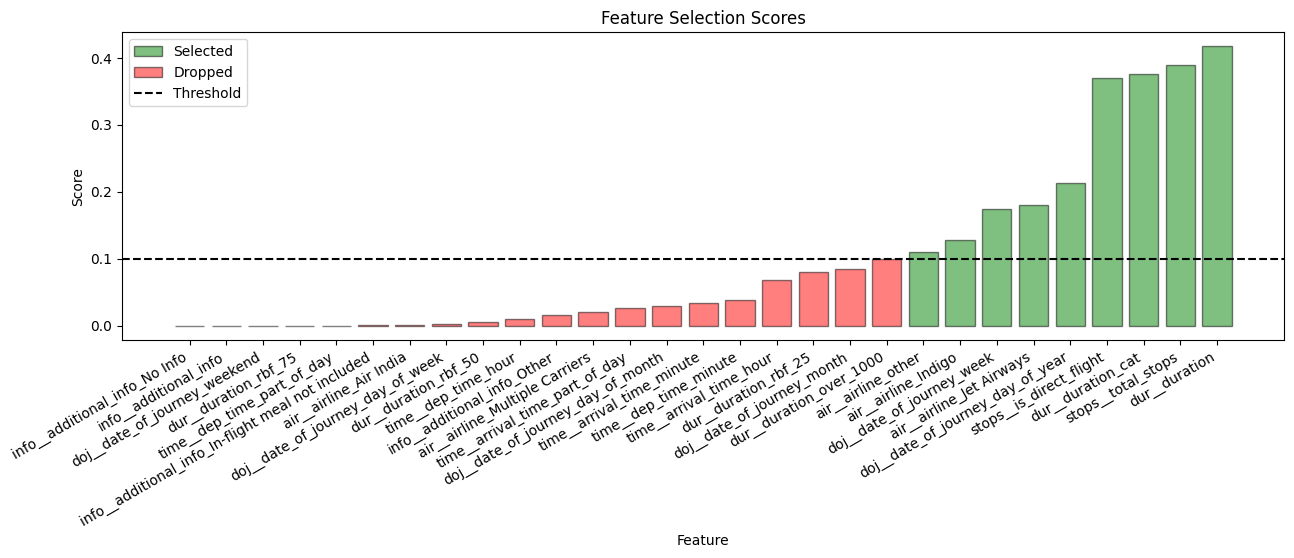

In [51]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()